In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, r2_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

X = pd.read_csv(r'C:\Users\Krish\Desktop\OneDrive - The University of Texas at Austin\UT Austin\Data Science Programming\Project\input.csv')
y = pd.read_csv(r'C:\Users\Krish\Desktop\OneDrive - The University of Texas at Austin\UT Austin\Data Science Programming\Project\output.csv')

Populating the interactive namespace from numpy and matplotlib


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = LogisticRegression()
result = model.fit(X_train, y_train)

from sklearn import metrics

prediction_train = model.predict(X_train)
print("Training accuracy is: ",metrics.accuracy_score(y_train, prediction_train))

prediction = model.predict(X_test)
print("Testing accuaracy is: ",metrics.accuracy_score(y_test, prediction))

weights = Series(model.coef_[0],
                 index=X.columns.values)
weights.sort_values()

Training accuracy is:  0.8429091529666078
Testing accuaracy is:  0.8398699316477537


Industry[T.Egg/Egg Prod]                             -1.392605
Industry[T.Vegetables/Vegetable Products]            -1.360528
Industry[T.Nuts/Edible Seed]                         -1.337168
Industry[T.Fruit/Fruit Prod]                         -0.963496
PHYSICAL_EXAMINATION                                 -0.948314
HYPOTRICHOSIS                                        -0.805263
Industry[T.Dressing/Condiment]                       -0.735218
MOUTH_INJURY                                         -0.726842
Industry[T.Cheese/Cheese Prod]                       -0.685928
BLOOD_CHOLESTEROL_INCREASED                          -0.632306
HEPATIC_FUNCTION_ABNORMAL                            -0.556018
Product_role[Concomitant]                            -0.537502
WOUND                                                -0.530109
Industry[T.Soup]                                     -0.522599
RENAL_IMPAIRMENT                                     -0.505216
GLOSSODYNIA                                          -0

In [5]:
# Log Regression functions

def run_LogisticReg(train_X, test_X, train_y, test_y, plot_graph, classification_thres, print_report ):
    
    model = LogisticRegression(class_weight='balanced',max_iter=5000, solver='lbfgs')
    model.fit(train_X, train_y)

    yhat = model.predict_proba(test_X)
    yhat_positive = yhat[:, 1]

    y_pred = (model.predict_proba(test_X)[:,1]>classification_thres).astype(bool)

    if print_report =='Yes':
        print(classification_report(test_y, y_pred))

    feature_importance = pd.DataFrame(train_X.columns, columns = ["feature"])
    feature_importance["importance"] = model.coef_[0]
    feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)[:20]

    if plot_graph == 'Yes':
        ax = feature_importance.plot.barh(x='feature', y='importance')
        plt.rcParams["figure.figsize"]=(10,10)
        plt.show()

    return yhat, yhat_positive, y_pred, feature_importance


def perform_cross_validation(X, y, n_splits1):

    kf = StratifiedKFold(n_splits=n_splits1,shuffle=True,random_state=42)
    pred_test_full =0
    recall_list = []
    precision_list = []
    accuracy_list = []
    roc_auc_list = []
    i=1

    for train_index,test_index in kf.split(X,y):
        
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr,xvl = X.loc[train_index],X.loc[test_index]
        ytr,yvl = y.loc[train_index],y.loc[test_index]
        
        yhat, yhat_positive, y_pred, feature_importance = run_LogisticReg(train_X=xtr, test_X=xvl, train_y=ytr, test_y=yvl, plot_graph='No',classification_thres=0.45, print_report='Yes' )
        
        precision = precision_score(y_pred=y_pred, y_true=yvl)
        recall = recall_score(y_pred=y_pred, y_true=yvl)
        accuracy = accuracy_score(y_pred=y_pred, y_true=yvl)
        roc_score = roc_auc_score(yvl, yhat_positive)

        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        roc_auc_list.append(roc_score)

        fpr, tpr, thresholds = metrics.roc_curve(yvl,  yhat_positive)
        length = len(thresholds)

        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, label='Logistic')
        idx_list  =np.linspace(0,length, num=20).astype(int)

        for ix in idx_list:
            try:
                plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=thresholds[ix])
                plt.text(fpr[ix], tpr[ix], str(round(thresholds[ix],2)))
            except:
                continue

#         #Calculate accuracy, precision_score, recall_score, specificity, confusion matrix and classification report
#         ps = precision_score(test_y, y_pred)
#         print('Precision Score =',ps)
#         rs = recall_score(test_y, y_pred)
#         print('Recall Score =',rs)
#         tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
#         specificity = tn / (tn+fp)
#         print('Specificity =',specificity)
#         cm = confusion_matrix(test_y, y_pred)
#         print(cm)
#         print(classification_report(test_y, y_pred))

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        i+=1

    return precision_list, recall_list, accuracy_list, roc_auc_list

             precision    recall  f1-score   support

          0       0.60      0.71      0.65      3505
          1       0.91      0.86      0.88     11564

avg / total       0.84      0.82      0.83     15069



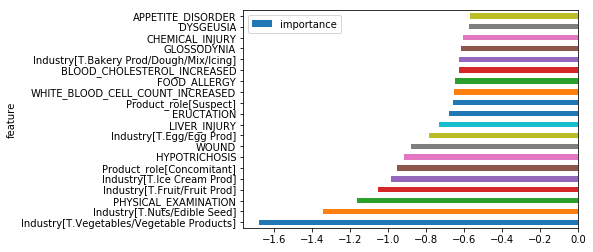

In [6]:
# running logistic regression considering all the features with l2 regularization

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = np.array(y_train)
X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = np.array(y_test)

yhat, yhat_positive, y_pred, feature_importance = run_LogisticReg(X_train, X_test, y_train, y_test, plot_graph='Yes',classification_thres=0.45, print_report='Yes' )

1 of KFold 5
             precision    recall  f1-score   support

          0       0.60      0.72      0.65      2349
          1       0.91      0.85      0.88      7698

avg / total       0.84      0.82      0.83     10047



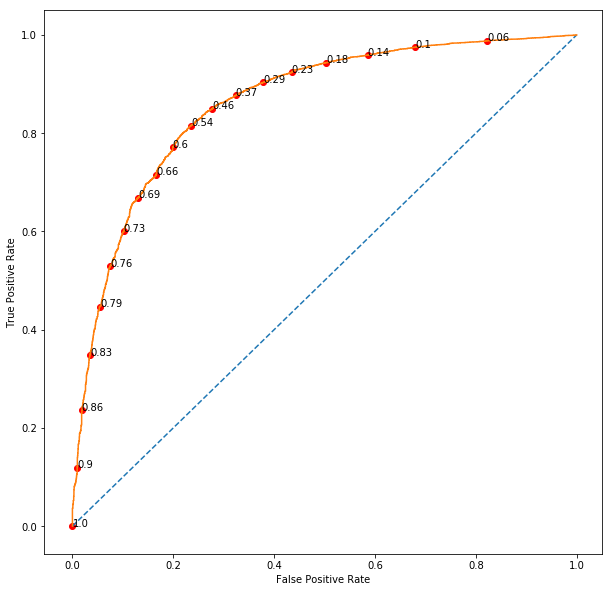

2 of KFold 5
             precision    recall  f1-score   support

          0       0.60      0.73      0.66      2348
          1       0.91      0.85      0.88      7697

avg / total       0.84      0.82      0.83     10045



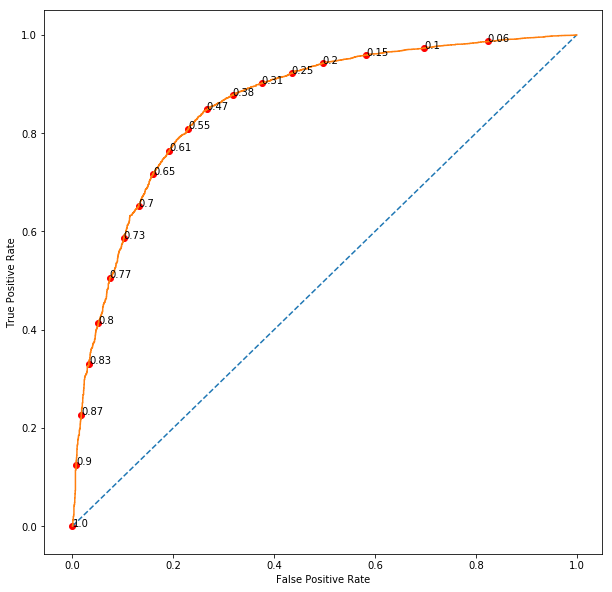

3 of KFold 5
             precision    recall  f1-score   support

          0       0.59      0.71      0.65      2348
          1       0.91      0.85      0.88      7697

avg / total       0.83      0.82      0.82     10045



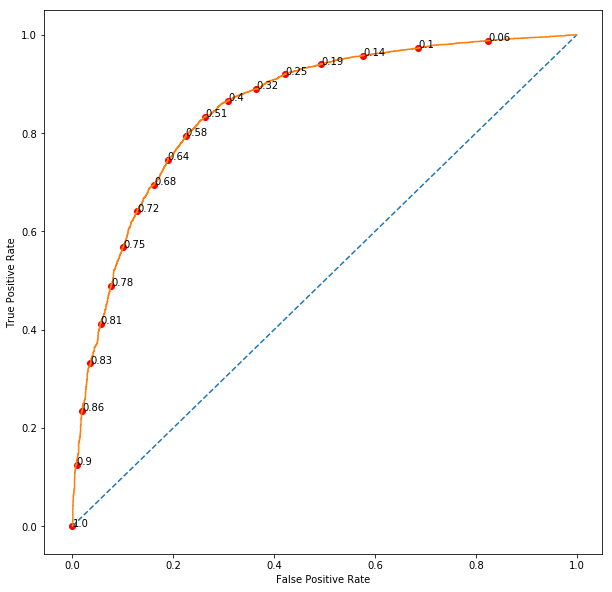

4 of KFold 5
             precision    recall  f1-score   support

          0       0.60      0.72      0.65      2348
          1       0.91      0.85      0.88      7697

avg / total       0.84      0.82      0.83     10045



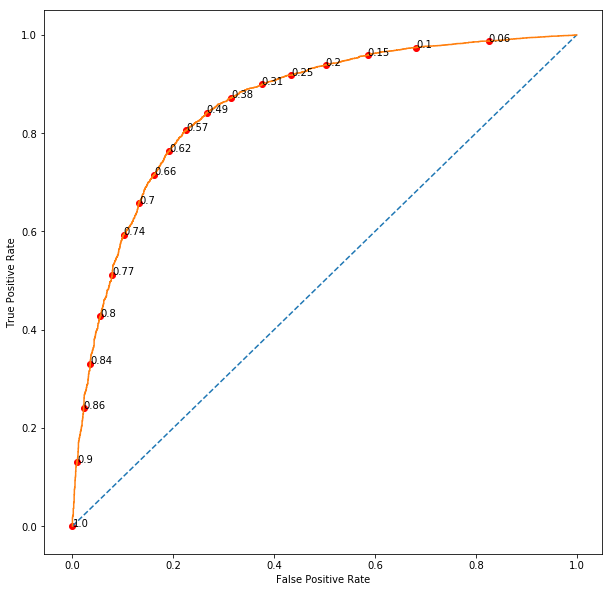

5 of KFold 5
             precision    recall  f1-score   support

          0       0.60      0.72      0.66      2348
          1       0.91      0.85      0.88      7697

avg / total       0.84      0.82      0.83     10045



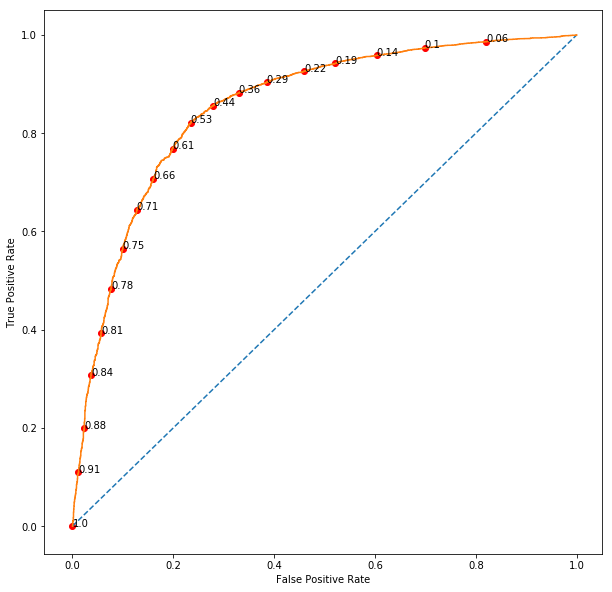

In [7]:
# Cross validation
precision_list1, recall_list1, accuracy_list1, roc_auc_list1 = perform_cross_validation(X,y,5)

In [20]:
def run_RandomForest(X_train, X_test, Y_train, Y_test, plot_graph, classification_thres ):
    
    #Random Forest model
    rf = RandomForestClassifier(n_estimators= 13, max_depth= 11, class_weight='balanced')
    rf.fit(X_train, Y_train)
    yhat = rf.predict_proba(X_test)
    yhat_positive = yhat[:, 1]
    y_pred = rf.predict(X_test)
    
    y_pred = (rf.predict_proba(X_test)[:,1]>0.45).astype(bool)
    print(classification_report(Y_test, y_pred))
    
    # calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(Y_test, yhat_positive)
    
    # Feature Importance
    feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
    feature_importance["importance"] = model.coef_[0]
    feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)[:20]

    if plot_graph == 'Yes':
        ax = feature_importance.plot.barh(x='feature', y='importance')
        plt.rcParams["figure.figsize"]=(10,10)
        plt.show()

    #Calculate ROC Score
    roc_score = roc_auc_score(Y_test, yhat_positive)
    print("ROC_AUC: "+ str(roc_score))
    print('\n')
    
    return yhat, yhat_positive, y_pred

#Cross Validation function

def perform_cross_validation(X, y, n_splits1):

    kf = StratifiedKFold(n_splits=n_splits1,shuffle=True,random_state=42)
    pred_test_full =0
    recall_list = []
    precision_list = []
    accuracy_list = []
    roc_auc_list = []
    i=1

    for train_index,test_index in kf.split(X,y):
        
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr,xvl = X.loc[train_index],X.loc[test_index]
        ytr,yvl = y.loc[train_index],y.loc[test_index]
        
        yhat, yhat_positive, y_pred = run_RandomForest(X_train=xtr, Y_train=ytr, X_test=xvl, Y_test=yvl, classification_thres=0.45)
        
        precision = precision_score(y_pred=y_pred, y_true=yvl)
        recall = recall_score(y_pred=y_pred, y_true=yvl)
        accuracy = accuracy_score(y_pred=y_pred, y_true=yvl)
        roc_score = roc_auc_score(yvl, yhat_positive)

        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        roc_auc_list.append(roc_score)

        fpr, tpr, thresholds = metrics.roc_curve(yvl,  yhat_positive)
        length = len(thresholds)

        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, label='Logistic')
        idx_list  =np.linspace(0,length, num=20).astype(int)

        for ix in idx_list:
            try:
                plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=thresholds[ix])
                plt.text(fpr[ix], tpr[ix], str(round(thresholds[ix],2)))
            except:
                continue

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        i+=1

    return precision_list, recall_list, accuracy_list, roc_auc_list

             precision    recall  f1-score   support

          0       0.59      0.70      0.64      2406
          1       0.90      0.85      0.87      7640

avg / total       0.83      0.81      0.82     10046



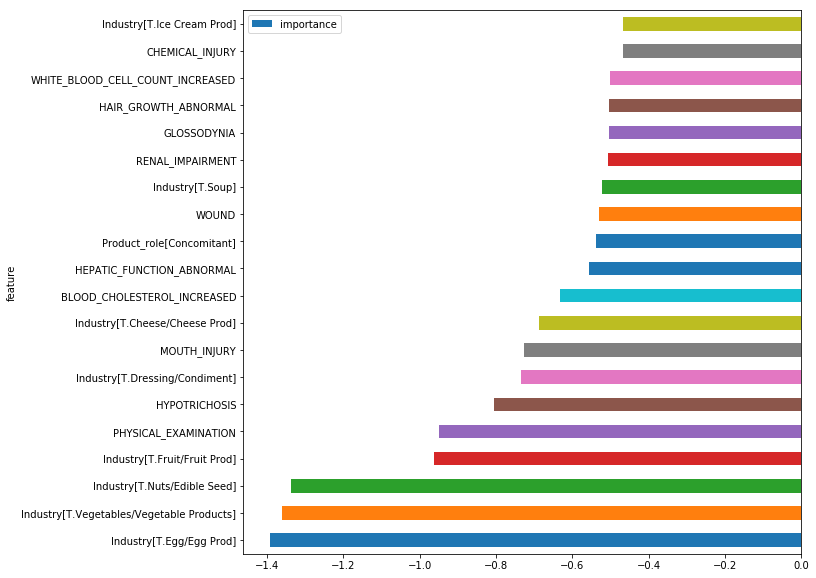

ROC_AUC: 0.8514271422229767




In [21]:
#Splitting the data into Training and Testing data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, train_size = 0.80, random_state= 42)

#Calling the Random Forest Function
yhat, yhat_positive, y_pred = run_RandomForest(X_train, X_test, Y_train, Y_test, plot_graph = 'Yes', classification_thres=0.45)

    Ival        Rs
0    1.0  0.810209
1    2.0  0.769764
2    3.0  0.752225
3    4.0  0.824869
4    5.0  0.805497
5    6.0  0.777356
6    7.0  0.816885
7    8.0  0.790445
8    9.0  0.823691
9   10.0  0.812435
10  11.0  0.839660
11  12.0  0.815707
12  13.0  0.821990
13  14.0  0.825131
14  15.0  0.816492
15  16.0  0.822120
16  17.0  0.811911
17  18.0  0.836649
18  19.0  0.836518
19  20.0  0.842147
20  21.0  0.840314
21  22.0  0.842539
22  23.0  0.836257
23  24.0  0.841361
24  25.0  0.850131
25  26.0  0.848037
26  27.0  0.847644
27  28.0  0.853534
28  29.0  0.854188
29  30.0  0.859424
30  31.0  0.858770
31  32.0  0.863743
32  33.0  0.858508
33  34.0  0.865183
34  35.0  0.872513
35  36.0  0.869372
36  37.0  0.874738
37  38.0  0.873037
38  39.0  0.877487
39  40.0  0.876571
40  41.0  0.875524
41  42.0  0.885209
42  43.0  0.884686
43  44.0  0.888351
44  45.0  0.886649
45  46.0  0.891099
46  47.0  0.892932
47  48.0  0.892147
48  49.0  0.892670


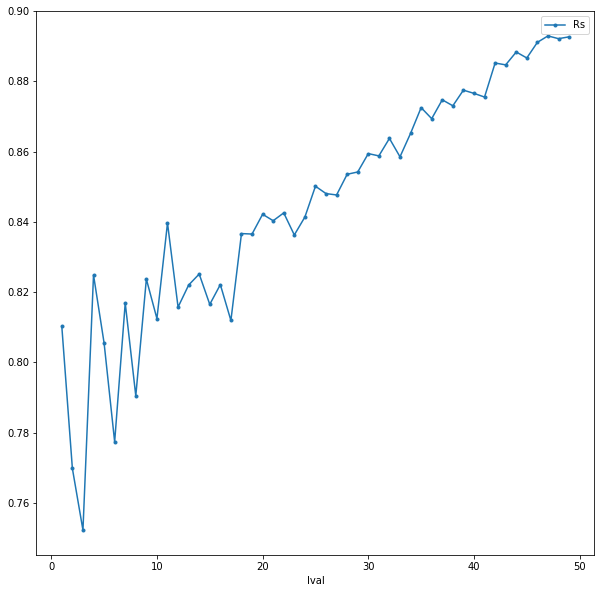

In [18]:
#To find the optimal tree depth
df = pd.DataFrame(columns=['Ival','Rs'])

for i in range(1,50):
    rf = RandomForestClassifier(n_estimators= 10, max_depth= i, class_weight='balanced')
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_test)
    rs = recall_score(Y_test, y_pred)
    df=df.append({'Ival':i,'Rs':rs},ignore_index=True)
print(df)
df.plot.line(x='Ival',y='Rs',style='.-')

    n_estimators        Rs
0            1.0  0.815445
1            2.0  0.850393
2            3.0  0.823429
3            4.0  0.827356
4            5.0  0.781152
5            6.0  0.824346
6            7.0  0.796990
7            8.0  0.777880
8            9.0  0.825131
9           10.0  0.829319
10          11.0  0.823953
11          12.0  0.820812
12          13.0  0.816230
13          14.0  0.831021
14          15.0  0.809555
15          16.0  0.811780
16          17.0  0.815969
17          18.0  0.819372
18          19.0  0.821335
19          20.0  0.832592
20          21.0  0.827356
21          22.0  0.817539
22          23.0  0.824084
23          24.0  0.806675
24          25.0  0.834162
25          26.0  0.823298
26          27.0  0.821335
27          28.0  0.841230
28          29.0  0.815838
29          30.0  0.816230
..           ...       ...
69          70.0  0.810995
70          71.0  0.825131
71          72.0  0.821335
72          73.0  0.821204
73          74.0  0.817670
7

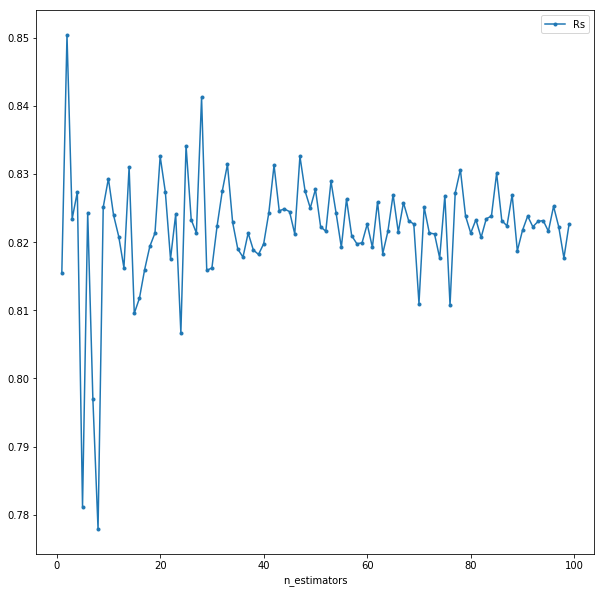

In [19]:
#To find the optimal number of estimators
df = pd.DataFrame(columns=['n_estimators','Rs'])

for j in range(1,100):
    rf = RandomForestClassifier(n_estimators= j, max_depth= 12, class_weight='balanced')
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_test)
    rs = recall_score(Y_test, y_pred)
    df=df.append({'n_estimators':j,'Rs':rs},ignore_index=True)
print(df)
df.plot.line(x='n_estimators',y='Rs',style='.-')

In [27]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=13, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

prediction_train = model.predict(X_train)
print("Training accuracy is: ",metrics.accuracy_score(y_train, prediction_train))

prediction = model.predict(X_test)
print("Testing accuaracy is: ",metrics.accuracy_score(y_test, prediction))

Training accuracy is:  0.5487229080152455
Testing accuaracy is:  0.5534541110889907
